# Download the dataset 

In [ ]:
'''
    !pip install CocoDataset==0.1.2
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip annotations_trainval2017.zip
'''

In [ ]:
from coco_dataset import coco_dataset_download as cocod
class_name='cup'  
images_count=50       
annotations_path='.annotations_trainval2017/annotations/instances_val2017.json' 
cocod.coco_dataset_download(class_name,images_count,annotations_path)

# Prepare Dataset

In [ ]:
'''
    Dataset used: 50 random samples from COCO Cup Dataset
    Data Annotation: Manual annotataion using Labelme tool (!pip install labelme)   
    
    Data Stored Path {
        Train data         -> models/research/object_detection/traindata/training
        Train annotation   -> models/research/object_detection/traindata/trainjson
        Test data          -> models/research/object_detection/traindata/training
        Test annotation    -> models/research/object_detection/traindata/testing
        Lable map          -> models/research/object_detection/data/cup_label_map.pbtxt
    }
    
    
    
    !python models/research/create_tf_records.py
                       -> OUTPUT: models/research/object_detection/data/cup_train.record
''' 

# Train the model

In [ ]:
'''
    1) Edit the file -> cup_maskrcnn_model/mask_rcnn_inception_v2_coco.config accordingly
        line numbers = 10, 133, 142, 144, 158, 160
    
    2) python models/research/train.py \
        --logtostderr \
        --train_dir=models/research/cup_maskrcnn_model_checkpoint/ \
        --pipeline_config_path=models/research/cup_maskrcnn_model_checkpoint/mask_rcnn_inception_v2_coco.config
'''

# Export the model

In [ ]:
'''
    python models/research/export_inference_graph.py --input_type image_tensor \
        --pipeline_config_path models/research/cup_maskrcnn_model_checkpoint/mask_rcnn_inception_v2_coco.config \
        --trained_checkpoint_prefix models/research/cup_maskrcnn_model_checkpoint/model.ckpt-1138 \
        --output_directory models/research/cup_maskrcnn_model_export
'''


# ------------------------------------------------------------------------------------------------

# Import the libraries for inference

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [13]:
%matplotlib inline

In [3]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
PATH_TO_FROZEN_GRAPH = os.path.join(os.getcwd(),
                                 "models",
                                 "research",
                                 "cup_maskrcnn_model_export",
                                 "frozen_inference_graph.pb")

PATH_TO_LABELS = os.path.join(os.getcwd(),
                              "models", 
                              "research", 
                              "object_detection",
                              "data",
                              "cup_label_map.pbtxt")

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

## Loading label map

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [7]:
category_index

{1: {'id': 1, 'name': 'cup'}}

In [9]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
        # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [15]:
PATH_TO_TEST_IMAGES_DIR = os.path.join(os.getcwd(), "sample_test_images")
# for a single input file, uncomment below line and comment the above line
# PATH_TO_TEST_IMAGES_DIR = [os.path.join(os.getcwd(), "<Path to input image file(extension)>")]
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in os.listdir(PATH_TO_TEST_IMAGES_DIR)]

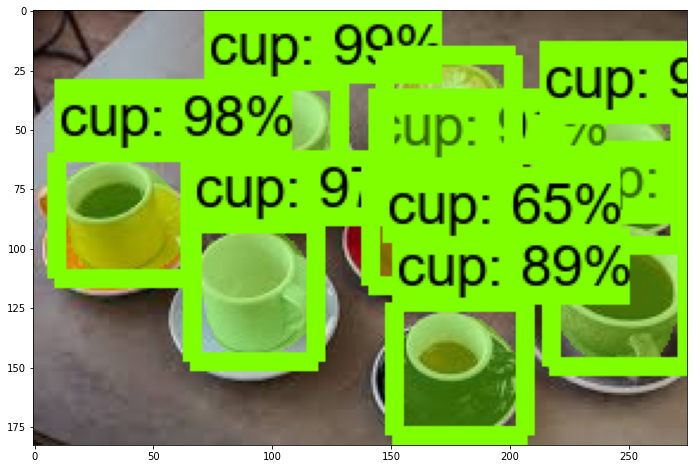

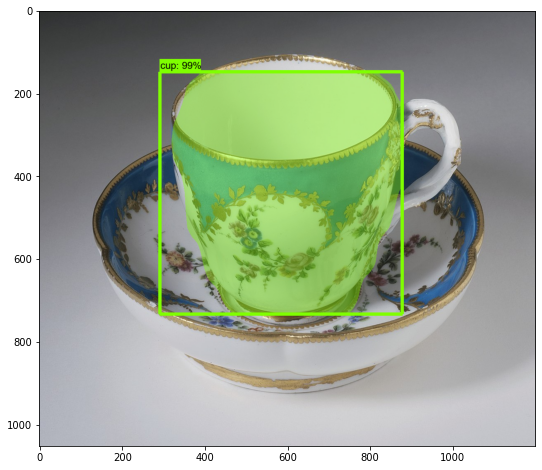

In [14]:
for image_path in TEST_IMAGE_PATHS:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image, axis=0)

    
    output_dict = run_inference_for_single_image(image, detection_graph)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)